In [1]:
import torch as tc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.stats import norm, multivariate_normal
sys.path.append(r'../') #path to folder where file that stored the results is located
from utils import calculate_effective_sample_size

plt.rc('font', family='serif', size=14)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [2]:
run = "./run_2022-12-09_17-56-58_normalizer/"

In [3]:
with open(run + "graphical_model.pkl", "rb") as f:
    model = pickle.load(f)

observed = []
observed_dict = {}
for var in model.topological():
    if var in model.Graph["Y"].keys():
        observed.append(tc.tensor(model.Graph["Y"][var]).float())
        observed_dict.update({var : tc.tensor(model.Graph["Y"][var]).float()})

observed = tc.stack(observed)
print("observed : {}".format(observed))
print("observed as dict : {}".format(observed_dict))

observed : tensor([160.3000, 220.8000, 200.6000, 139.4000, 178.6000, 119.4000])
observed as dict : {'observe5': tensor(160.3000), 'observe8': tensor(220.8000), 'observe7': tensor(200.6000), 'observe4': tensor(139.4000), 'observe6': tensor(178.6000), 'observe3': tensor(119.4000)}


In [13]:
def get_samples(epoch, observed, observed_dict, num_samples=2000):
    proposal_samples = []
    proposal_weights = []
    model_weights = []
    weights = []
    with open(run + "proposal_epoch{}.pkl".format(epoch), "rb") as f:
        proposal = pickle.load(f)
    with open(run + "/model.pkl", "rb") as f:
        model = pickle.load(f)
    with open(run + "normalizer.pkl", "rb") as f:
        normalizer = pickle.load(f)

    for i in range(num_samples):
        sample_dict = proposal.sample(y = observed)
        sample_tensor = tc.stack([sample_dict[latent] for latent in model.latent_ordered_vars]) #topological order
        sample_tensor_denorm = normalizer.denormalize(sample_tensor, observed) #topological order
        sample_dict_denorm = {latent : sample_tensor_denorm[i] for i,latent in enumerate(model.latent_ordered_vars)}

        proposal_samples.append(sample_tensor_denorm) #sample in the topological order
        model_weights.append(model.log_prob({**sample_dict_denorm, **observed_dict}).detach().clone())
        proposal_weights.append(proposal.log_prob(sample_tensor, observed).detach().clone())
        weights.append(tc.exp(model_weights[i] - proposal_weights[i]))
        #print("=> proposal weight : {}, model weight : {}, sample : {}".format(proposal_weights[i], model_weights[i], sample_tensor))

    proposal_samples = tc.stack(proposal_samples)
    proposal_weights = tc.stack(proposal_weights)
    model_weights = tc.stack(model_weights)
    calculate_effective_sample_size(tc.stack(weights), verbose=True)
    weights = tc.stack(weights).numpy()
    weights /= weights.sum()
    

    idx = np.random.choice(np.arange(len(weights)), size=len(weights), p=weights)
    resamples = proposal_samples[idx]
    return proposal_samples, resamples
    

In [14]:
proposal_samples, resamples = get_samples(epoch = 7, observed = observed, observed_dict=observed_dict, num_samples=3000)
proposal_samples = proposal_samples.numpy()
resamples = resamples.numpy()

Sample size: 3000
Effective sample size: tensor(96.7667)
Fractional sample size: tensor(0.0323)
Sum of weights: tensor(1.)


In [15]:
df1 = pd.DataFrame(proposal_samples, columns = ["slope", "bias"])
df2 = pd.DataFrame(resamples, columns = ["slope", "bias"])
samples_dict = {"proposal" : {"slope" : df1["slope"], "bias" : df1["bias"]},
                "posterior" :{"slope" : df2["slope"], "bias" : df2["bias"]}}

In [16]:
# Make a triangle plot to see slope and bias distributions and correlations
def triangle_plot(samples_dict, mu=None, cov=None, **kwargs):
    plt.subplots(2, 2, **kwargs)
    plt.subplot(2, 2, 1)
    for name, samples in samples_dict.items():
        plt.hist(samples['bias'], alpha=0.7, density=True, bins='auto', label=name)
    if mu is not None and cov is not None:
        x, f = get_distribution(plt, mu[0], np.sqrt(cov[0, 0]))
        plt.plot(x, f, color='black', label='analytical')
    plt.gca().set_xticklabels([])
    plt.yticks([])
    plt.legend(prop={'size': 12})
    plt.subplot(2, 2, 4)
    for name, samples in samples_dict.items():
        plt.hist(samples['slope'], alpha=0.7, density=True, bins='auto', label=name)
    if mu is not None and cov is not None:
        x, f = get_distribution(plt, mu[1], np.sqrt(cov[1, 1]))
        plt.plot(x, f, color='black', label='analytical')
    plt.xlabel('slope')
    plt.yticks([])
    plt.subplot(2, 2, 3)
    for name, samples in samples_dict.items():
        plt.scatter(samples['bias'], samples['slope'], alpha=0.5, s=5., label=name)
    if mu is not None and cov is not None:
        X, Y, Z = get_contours(plt, mu, cov)
        plt.contour(X, Y, Z, colors='black', alpha=0.9, levels=3)
    plt.xlabel('bias')
    plt.ylabel('slope')
    plt.subplot(2, 2, 2).axis('off')
    plt.tight_layout()
    plt.show()

# Plot the learning curves to see how training is progressing
def plot_learning_curve(training_logfile, **kwargs):
    data = np.loadtxt(training_logfile, skiprows=1, delimiter=',', converters={8: lambda _: 0.})
    plt.figure(**kwargs)
    plt.plot(data[:, 1], data[:, 3], label='training')
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Analytical expression for the posterior covariance
def analytical_covariance(x, sigma, alpha):
    cov1 = np.identity(2)*(sigma/alpha)**2
    x0_sum = len(x)
    x1_sum = np.sum(x)
    x2_sum = np.sum(x**2)
    cov2 = np.array([
        [x0_sum, x1_sum],
        [x1_sum, x2_sum],
    ])
    cov = (1./sigma**2)*(cov1+cov2)
    cov = np.linalg.inv(cov)
    return cov

# Analytical expression for the posterior mean
def analytical_mean(x, y, sigma, alpha, m0 = np.array([0.0, 0.0])):
    xy_sum = np.sum(x*y)
    y_sum = np.sum(y)
    vec = np.array([y_sum, xy_sum]) + m0 @ np.identity(2)*(sigma/alpha)**2
    cov = analytical_covariance(x, sigma, alpha)
    mu = np.matmul(cov, vec)/sigma**2
    return mu

# Distribution for 1D marginal posteriors
def get_distribution(plt, mu, sig, N=200):
    xlim = plt.gca().get_xlim()
    x = np.linspace(xlim[0], xlim[1], N)
    rv = norm(mu, sig)
    f = rv.pdf(x)
    return x, f

# Contours for 2D posterior distributions
def get_contours(plt, mu, cov, N=200):
    xlim = plt.gca().get_xlim(); ylim = plt.gca().get_ylim()
    X = np.linspace(xlim[0], xlim[1], N)
    Y = np.linspace(ylim[0], ylim[1], N)
    X, Y = np.meshgrid(X, Y); pos = np.dstack((X, Y))
    rv = multivariate_normal(mu, cov)
    Z = rv.pdf(pos)
    return X, Y, Z


In [17]:
x = np.array([1., 2., 3., 4., 5., 6.])
sigma = 1.0  # Likelihood error
alpha = 5.0 # Prior scale
obs_np = observed.numpy()
mu = analytical_mean(np.array(x), np.sort(obs_np), sigma, alpha, m0=np.array([100.0, 20.0]))
cov = analytical_covariance(np.array(x), sigma, alpha)
print(mu, np.sqrt(cov[0,0]), np.sqrt(cov[1,1]))
print(cov)

[98.99665981 20.24571854] 0.9144056007485643 0.23552728304075626
[[ 0.8361376  -0.19287005]
 [-0.19287005  0.0554731 ]]


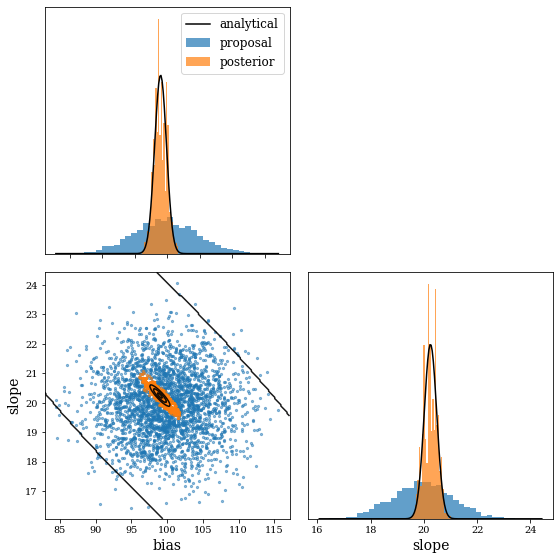

In [18]:
triangle_plot(samples_dict, mu, cov, figsize=(8,8))


In [60]:
observed = []
for var in model.topological():
    if var in model.Graph["Y"].keys():
        observed.append(tc.tensor(model.Graph["Y"][var]).float())

observed = tc.stack(observed)

observed_test1 = np.random.normal(1 * x + 3, scale = sigma)
observed_test1 = tc.tensor(observed_test1[observed.argsort().argsort()]).float()

observed_test2 = np.random.normal(5 * x + 8, scale = sigma)
observed_test2 = tc.tensor(observed_test2[observed.argsort().argsort()]).float()

observed_test3 = np.random.normal(9 * x + 13, scale = sigma)
observed_test3 = tc.tensor(observed_test3[observed.argsort().argsort()]).float()

In [61]:
def plot_proposal_by_epochs(epochs : int, observed : tc.Tensor, model, num_samples = 2000, **kwargs):
    
    latents = [var for var in model.topological() if var.startswith("sample")]
    fig, axs = plt.subplots(2, epochs, **kwargs)

    x = np.array([1., 2., 3., 4., 5., 6.])
    mu = analytical_mean(np.array(x), np.sort(observed), sigma, alpha)
    cov = analytical_covariance(np.array(x), sigma, alpha)

    for i, latent in enumerate(latents):
        for epoch in range(epochs):
            with open(run + "proposal_epoch{}.pkl".format(epoch), "rb") as f:
                proposal = pickle.load(f)
            
            proposal_samples = []
            for _ in range(num_samples):
                sample = proposal.sample(y = observed)[latent]
                proposal_samples.append(sample)

            proposal_samples = tc.stack(proposal_samples).numpy()
            axs[i,epoch].hist(proposal_samples, bins="auto", label="Epoch {}".format(epoch + 1), density=True)
            xlim = axs[i,epoch].get_xlim()
            x = np.linspace(xlim[0], xlim[1], 5000)
            rv = norm(mu[1-i], np.sqrt(cov[1-i,1-i]))
            f = rv.pdf(x)
            
            axs[i,epoch].plot(x, f, label="Analytical posterior")

            axs[i,epoch].legend(loc="upper right", prop = {"size" : 12})
    
    axs[0,0].set_ylabel("slope")
    axs[1,0].set_ylabel("bias")

torch.return_types.sort(
values=tensor([ 2.0500,  3.9400,  5.9000,  8.0300, 10.1000, 11.8600]),
indices=tensor([5, 3, 0, 4, 2, 1]))


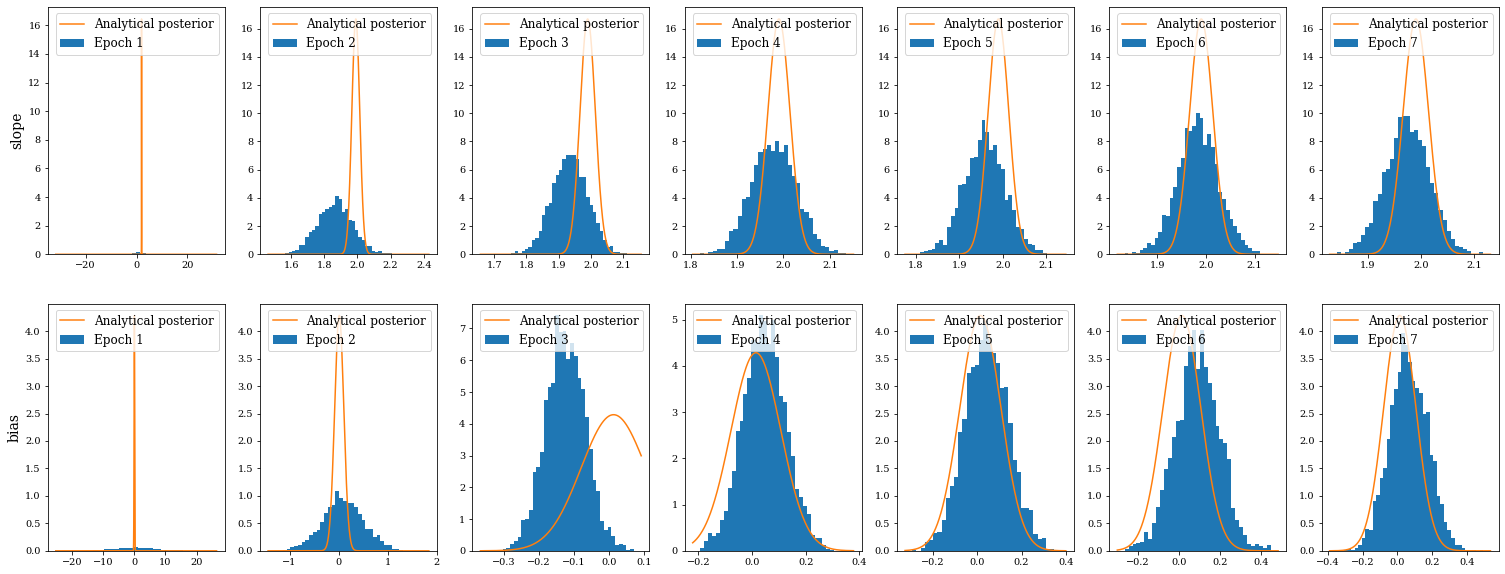

In [63]:
plot_proposal_by_epochs(epochs=7, observed=observed, model=model, num_samples=3000, figsize=(26,10))
print(observed.sort())
# y = 2x + 0

torch.return_types.sort(
values=tensor([3.9494, 4.9548, 5.8313, 7.0786, 8.1524, 9.1087]),
indices=tensor([5, 3, 0, 4, 2, 1]))


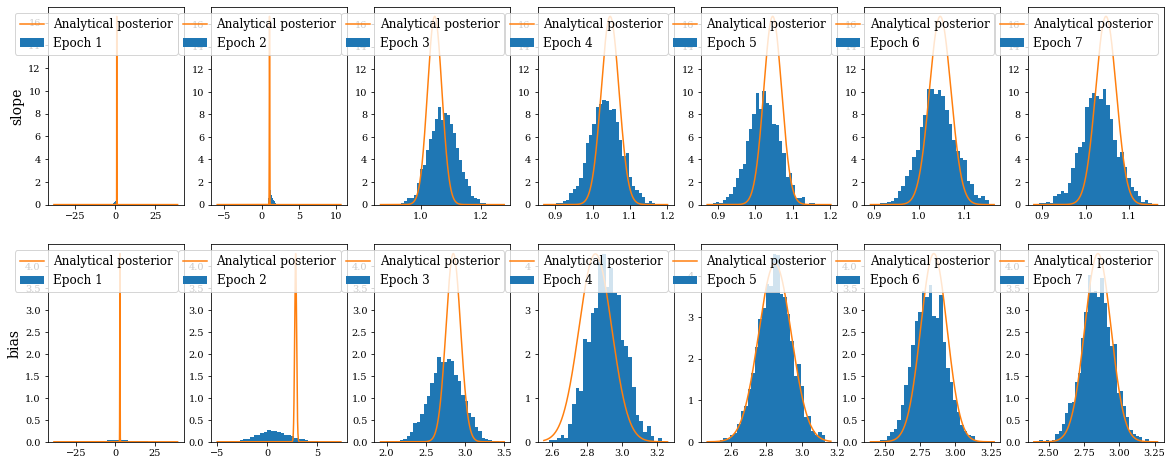

In [64]:
plot_proposal_by_epochs(epochs=7, observed=observed_test1, model=model, figsize=(20,8))
print(observed_test1.sort())
# y = x + 3

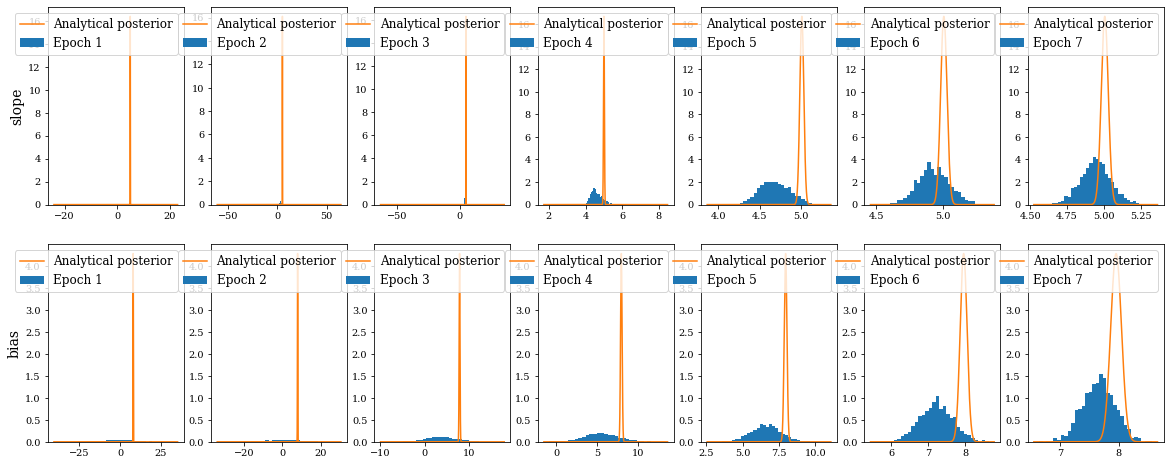

In [65]:
plot_proposal_by_epochs(epochs=7, observed=observed_test2, model=model, figsize=(20,8))
# y = 5x + 8

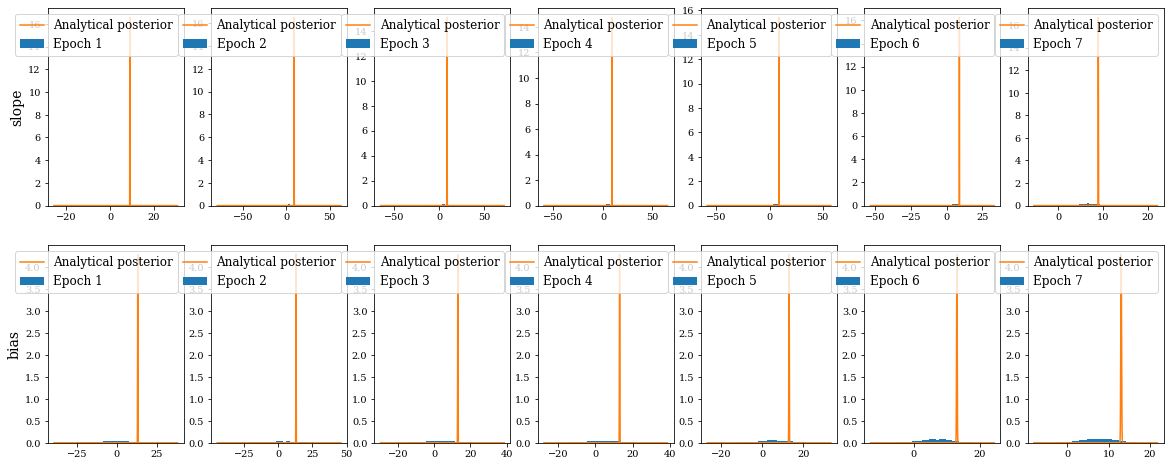

In [66]:
plot_proposal_by_epochs(epochs=7, observed=observed_test3, model=model, figsize=(20,8))
# y = 9x + 13

In [67]:
def plot_losses(**kwargs):
    losses = tc.load(run + "losses.pt")
    fig, axs = plt.subplots(1, len(losses), **kwargs)
    for i, loss in enumerate(losses):
        axs[i].plot(loss, label="epoch {}".format(i))
        axs[i].legend()
    return


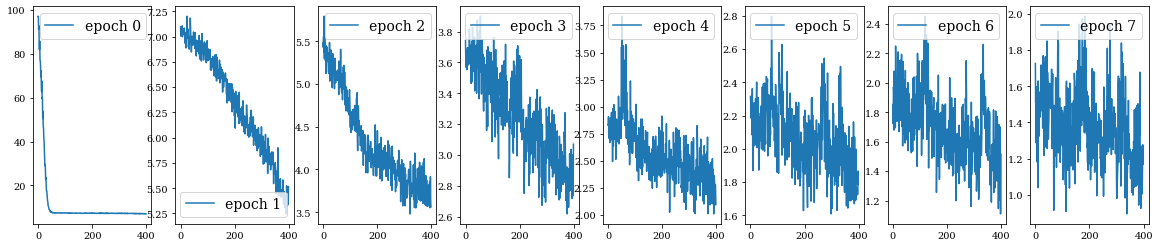

In [68]:
plot_losses(figsize=(20,4))

In [73]:
np.random.normal(20 * np.arange(1,7) + 100, scale=1.0)

array([119.34972614, 139.41502425, 160.26129668, 178.56141634,
       200.61280277, 220.82670659])